In [1]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True
torch.set_printoptions(precision=4, sci_mode=False)

img_wh = (200, 200)

# dataset = dataset_dict['llff'] \
#           ('/home/ubuntu/data/nerf_example_data/my/fountain/', 'test', spheric_poses=True,
#            img_wh=img_wh)

dataset = dataset_dict['blender'] \
          ('/home/ubuntu/data/nerf_example_data/nerf_synthetic/lego/', 'test_train',
           perturbation=['occ'],
           img_wh=img_wh)

In [2]:
encode_appearance = False
N_a = 48
encode_transient = True
N_tau = 16
beta_min = 0.1

ckpt_path = 'ckpts/lego_nerfw_occ/epoch=9.ckpt'

embedding_xyz = PosEmbedding(9, 10)
embedding_dir = PosEmbedding(3, 4)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(200, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
if encode_transient:
    embedding_t = torch.nn.Embedding(200, N_tau).cuda()
    load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
    embeddings['t'] = embedding_t
    

nerf_coarse = NeRF('coarse').cuda()
nerf_fine = NeRF('fine',
                 encode_appearance=encode_appearance,
                 in_channels_a=N_a,
                 encode_transient=encode_transient,
                 in_channels_t=N_tau,
                 beta_min=beta_min).cuda()

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [3]:
N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32

@torch.no_grad()
def f(rays, ts):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [4]:
sample = dataset[1]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

t = time.time()
results = f(rays, ts)
torch.cuda.synchronize()
print(time.time()-t)

3.5003790855407715


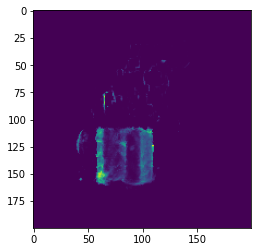

In [5]:
plt.imshow(results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy())

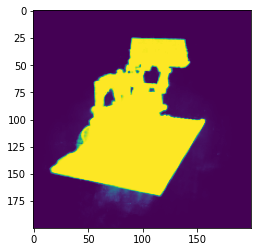

In [6]:
plt.imshow(results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy())

PSNR 27.587690353393555


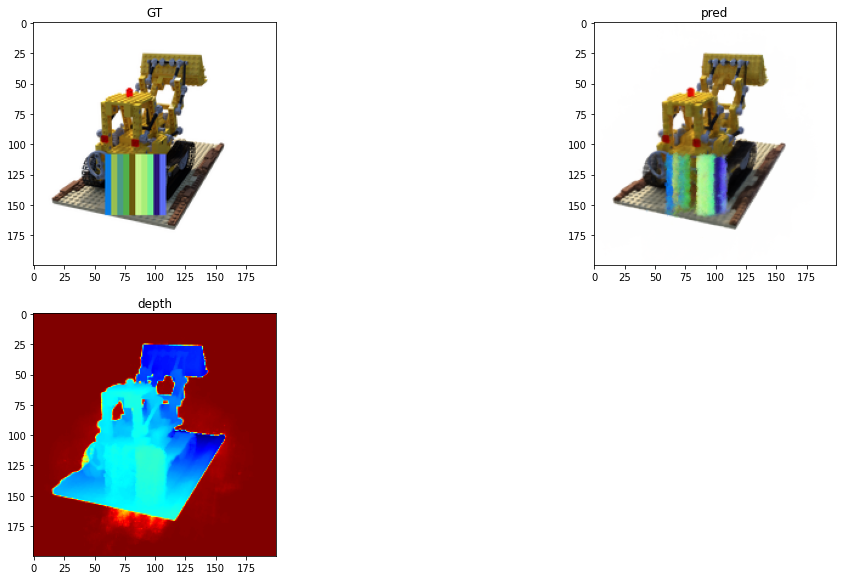

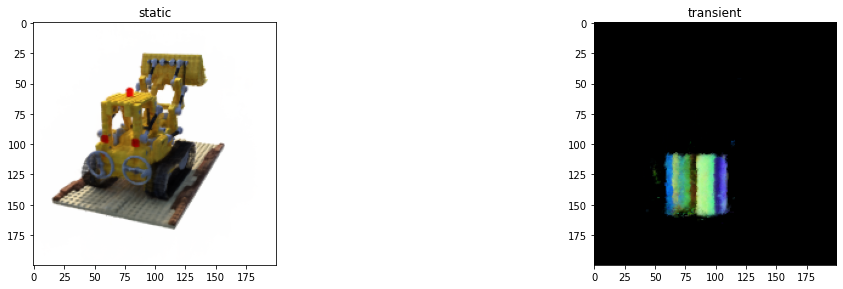

In [12]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

if encode_transient:
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(221)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(222)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.show()